<a href="https://colab.research.google.com/github/RichardKameri/FINAL_PROJECT_SENTIMENT_ANALYSISNT-/blob/main/KQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kenya Airways Customer Review Sentiment Analysis
Kenya Airways Logo
**bold text**
**Business Overview**

Kenya Airways is among the top airlines in Africa, and in Kenya, it holds a prominent position as the flag carrier and the largest airline in the country. Since its establishment in 1977, Kenya Airways has been a key player in both domestic and international air travel, connecting Kenya to various destinations around the world. The airline is known for its commitment to providing safe, reliable, and comfortable air travel experiences to its passengers. Over the years, Kenya Airways has built a strong brand reputation, emphasizing its African heritage and hospitality.

**Project Overview**

The aim of this project is to conduct sentiment analysis on customer reviews related to Kenya Airways. By analyzing the sentiments expressed in these reviews, we seek to gain insights into how customers perceive their experiences with the airline's services. This analysis will provide valuable feedback that can be used to enhance customer satisfaction, identify areas for improvement, and make informed business decisions to maintain and improve the airline's reputation.

Project Objectives


Sentiment Classification: Develop a sentiment classification model that can accurately categorize customer reviews into positive, negative, or neutral sentiments. This model will help automate the process of analyzing large volumes of reviews.

Feedback Analysis: Identify common themes and specific aspects mentioned in the reviews, such as in-flight services, customer service, booking process, seating comfort, and more. This will provide a comprehensive understanding of what aspects are contributing to positive or negative sentiments.

**Data Importation**

In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
def scrape_airline_reviews(base_url, pages, page_size):
    reviews = []
    date = []

    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        response = requests.get(url)
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')

        for review in parsed_content.find_all("article", {"itemprop": "review"}):
            # Extract review text
            review_text = review.find("div", {"class": "text_content"}).get_text()
            reviews.append(review_text)

            # Extract date
            try:
                review_date = review.find("div", {"class": "body"}).find("time").get_text()
            except AttributeError:
                review_date = "N/A"
            date.append(review_date)

        print(f"   ---> {len(reviews)} total reviews")

    return reviews, date

# Define parameters
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways/"
pages = 20
page_size = 100

# Call the function
reviews, date = scrape_airline_reviews(base_url, pages, page_size)

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 496 total reviews
Scraping page 6
   ---> 496 total reviews
Scraping page 7
   ---> 496 total reviews
Scraping page 8
   ---> 496 total reviews
Scraping page 9
   ---> 496 total reviews
Scraping page 10
   ---> 496 total reviews
Scraping page 11
   ---> 496 total reviews
Scraping page 12
   ---> 496 total reviews
Scraping page 13
   ---> 496 total reviews
Scraping page 14
   ---> 496 total reviews
Scraping page 15
   ---> 496 total reviews
Scraping page 16
   ---> 496 total reviews
Scraping page 17
   ---> 496 total reviews
Scraping page 18
   ---> 496 total reviews
Scraping page 19
   ---> 496 total reviews
Scraping page 20
   ---> 496 total reviews


In [3]:
# Create a Dataframe to store the data

df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,"✅ Trip Verified | Terrible experience, 12 hr...",23rd January 2025
1,✅ Trip Verified | I just completed a direct fl...,30th December 2024
2,✅ Trip Verified | Worst airline I've ever de...,24th December 2024
3,"Not Verified | By far, the worst customer ser...",4th December 2024
4,Not Verified | My experience with Kenya Airwa...,4th December 2024


In [48]:
# Saves the dataframe as a csv file in the data folder.

cwd = os.getcwd()
df.to_csv(cwd + "/data/KQ_reviews.csv")

In [4]:
import os

# ... your existing code ...

# Create the 'data' directory if it doesn't exist

# Saves the dataframe as a csv file in the data folder.
cwd = os.getcwd()
df.to_csv(cwd + "/data/KQ_reviews.csv")

In [5]:
# Inspect index 0

df['reviews'].get(0)

'✅ Trip Verified |   Terrible experience, 12 hrs stuck in Nairobi. Getting emails about flight delay due to technical fault but none of the staff in the airport aware. No real life support provided. Terrible service from this airline. Avoid if possible.'

In [6]:
# Class used to Describe the Data

class Describer:

    # initialize object
    def __init__(self, df):
        self.df = df

    # method to check shape of data
    def shape(self):
        shape_df = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return shape_df

    # method to check info on dataset
    def data_info(self):
        info_df = print(self.df.info(), '\n')
        return info_df

    # method to describe numerical columns
    def data_describe(self):
        num_col = self.df.describe()
        return num_col

In [7]:
# creating an instance of the class describer
describe_df = Describer(df)

# Viewing the shape of the data
describe_df.shape()

The DataFrame has:
	* 496 rows
	* 2 columns 



In [8]:
# summary information
print('Summary infomation on dataset')
print('______________________________')
describe_df.data_info()

Summary infomation on dataset
______________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  496 non-null    object
 1   date     496 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB
None 



Data **Cleaning**

In [9]:
# Convert the date column to date time

df['date'] = pd.to_datetime(df['date'].str.replace(r'(?<=\d)(st|nd|rd|th)', '', regex=True))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   reviews  496 non-null    object        
 1   date     496 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 7.9+ KB


In [49]:
# information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   reviews         496 non-null    object        
 1   date            496 non-null    datetime64[ns]
 2   word_count      496 non-null    int64         
 3   verified        496 non-null    bool          
 4   corpus          496 non-null    object        
 5   sentiment       496 non-null    int64         
 6   sentiment_type  496 non-null    object        
 7   label           496 non-null    int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(3)
memory usage: 27.7+ KB


**Data Understanding**

The data was scraped using BeautifulSoup from this website. The website contains various reviews related to Air Travel.

In [50]:
# Function to calculate word count
def word_count(text):
    words = text.split()
    return len(words)

# Calculate word count for each review
df['word_count'] = df['reviews'].apply(word_count)

# Calculate and print the average word count
avg_word_count = df['word_count'].mean()

# Display the updated DataFrame
avg_word_count

152.29032258064515

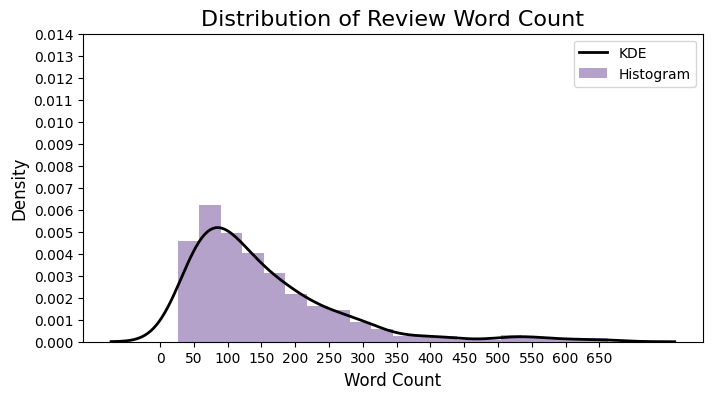

In [51]:
# Plot a histogram of the word counts
fig = plt.figure(figsize=(8, 4))

plt.hist(df['word_count'], bins=20, color='#967bb6', alpha=0.7, density=True)

# KDE plot
sns.kdeplot(df['word_count'], color='black', linewidth=2)

plt.title('Distribution of Review Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(np.arange(0, 700, 50))
plt.yticks(np.arange(0, 0.015, 0.001))

plt.legend(labels=['KDE', 'Histogram'])

plt.show()

In [12]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")

**Data Pre-Processing**


Data preprocessing in NLP sentiment analysis involves cleaning and structuring text data for accurate analysis. It includes steps like removing special characters, tokenizing text, eliminating common words, stemming or lemmatization, handling negations, and converting text into numerical vectors. This ensures that the text data is ready for machine learning models and results in more reliable sentiment analysis outcomes.

In [52]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# Creates a new column that extracts the information on whether the trip is verified or not

reviews_data = df.reviews.str.strip("Trip Verified |")
corpus =[]
# Instantiate the WordNetLemmatizer
lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = " ".join(rev)
    corpus.append(rev)

In [15]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(10)

,reviews,date,word_count,verified
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False
5,My wife flew Kigali-Dar return November 2024. ...,2024-12-02,121,True
6,First flight I was appalled by the state of th...,2024-11-30,64,True
7,Not Verified | Avoid Kenya Airways at all cost...,2024-11-29,155,False
8,"On 24th November 2024, I flew from Lagos to Mu...",2024-11-28,392,True
9,"In late July 2024, our flight from Zanzibar to...",2024-10-28,163,True


In [16]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df


,reviews,date,word_count,verified,corpus
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True,trip verified terrible experience hrs stuck in...
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True,trip verified i just completed a direct flight...
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True,trip verified worst airline i ve ever dealt wi...
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...
...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...


In [54]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
# an instance of SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon') #Download the VADER lexicon.
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,reviews,date,word_count,verified,corpus,sentiment,sentiment_type,label
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,38,True,trip verified terrible experience hrs stuck in...,-0.8820,negative,-1
1,I just completed a direct flight from NBO to J...,2024-12-30,129,True,trip verified i just completed a direct flight...,-0.8093,negative,-1
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,183,True,trip verified worst airline i ve ever dealt wi...,0.6164,positive,1
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...,-0.9459,negative,-1
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...,0.6446,positive,1
...,...,...,...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...,0.8201,positive,1
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...,0.9826,positive,1
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...,0.9485,positive,1
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...,0.6808,positive,1


In [19]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'sentiment' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df

,reviews,date,word_count,verified,corpus,sentiment,sentiment_type
0,"Terrible experience, 12 hrs stuck in Nairobi. ...",2025-01-23,42,True,trip verified terrible experience hrs stuck in...,-0.8820,negative
1,I just completed a direct flight from NBO to J...,2024-12-30,133,True,trip verified i just completed a direct flight...,-0.8093,negative
2,Worst airline I've ever dealt with. 4hr delay ...,2024-12-24,187,True,trip verified worst airline i ve ever dealt wi...,0.6164,positive
3,"Not Verified | By far, the worst customer ser...",2024-12-04,221,False,not verified by far the worst customer service...,-0.9459,negative
4,Not Verified | My experience with Kenya Airwa...,2024-12-04,118,False,not verified my experience with kenya airways ...,0.6446,positive
...,...,...,...,...,...,...,...
491,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,113,False,jnb nbo jnb this trip showed both the good and...,0.8201,positive
492,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,279,False,nairobi london lounge in nairobi was small and...,0.9826,positive
493,Nairobi-London. As me and my wife are both whe...,2011-07-11,177,False,nairobi london as me and my wife are both whee...,0.9485,positive
494,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,49,False,lun llw in economy adequate for a hr trip fa w...,0.6808,positive


**Exploratory Data Analysis (EDA)**

In this stage EDA is also done on the dataset to gain more insights on the data that is available.

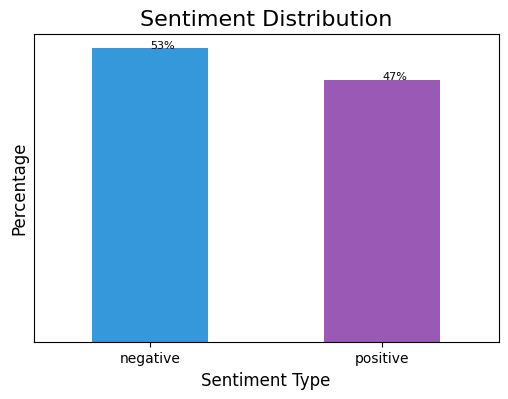

In [20]:
# Calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True) * 100

# Define custom colors for the bars

bar_colors = ['#3498db', '#9b59b6']

# Plot the sentiment percentages as a bar plot
fig, ax = plt.subplots(figsize=(6, 4))
sent_type_percentages.plot(kind='bar', color=bar_colors, ax=ax)

# Add data labels on the bars with two decimal points
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='left', va='baseline', fontsize=8, color='black')

ax.set_title('Sentiment Distribution', fontsize=16)
ax.set_xlabel('Sentiment Type', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_xticklabels(sent_type_percentages.index, rotation=0)
ax.set_yticks([])  # Hide y-axis ticks

plt.show()

Negative reviews account for 51% of the dataset, and positive reviews account for 49% of the dataset.
Understanding what is the reason behind the negative reviews is the main concern of this project.

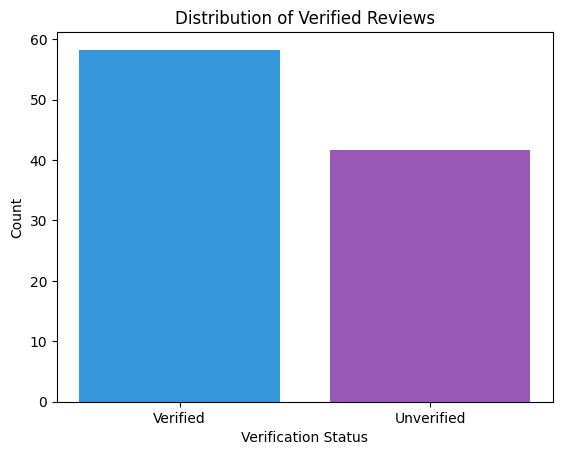

In [21]:
# Calculate the counts of verified and unverified reviews
verified_counts = df['verified'].value_counts(normalize=True)*100

# Define custom colors for the bars
bar_colors = ['#3498db', '#9b59b6']

# Create the bar chart with custom colors
plt.bar(verified_counts.index, verified_counts.values, color=bar_colors)

# Add labels and title
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Distribution of Verified Reviews')

# Customize x-axis tick labels
plt.xticks(verified_counts.index, ['Verified', 'Unverified'])

# Show the plot
plt.show()

Majority of the reviews have been verified.

In [22]:
# Cleaned data
df.to_csv( cwd + "/data/reviews_cleaned.csv")

In [23]:
# Time Series Analysis on the Date column
fig = px.line(df, x='date')
fig.show()


There is a decline on the number of reviews that have been shared

In [56]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words

words = []
for review in reviews:
    words.extend(review.split())


# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]

In [57]:
# Get the top 20 most used words
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]

In [26]:
# stop words
stopwords = set(nltk.corpus.stopwords.words('english')) - {'not'}

def Text_preprocessing(Text):
    Processed_Text = list()
    lemmatizer = WordNetLemmatizer()

    # Token of words
    Tokens = nltk.word_tokenize(Text)

    # Removing Stopwords and Lemmatizing Words
    # To reduce noises in our dataset, also to keep it simple and still
    # powerful, we will only omit the word `not` from the list of stopwords

    for word in Tokens: # Fixed indentation here
        if word not in stopwords:  # Make sure 'Stopwords' is 'stopwords'
            Processed_Text.append(lemmatizer.lemmatize(word))  # Make sure 'Lemmatizer' is 'lemmatizer'

    return(" ".join(Processed_Text))

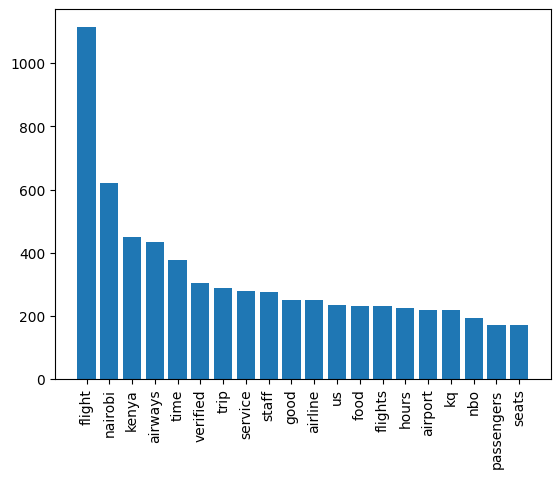

In [27]:
# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()

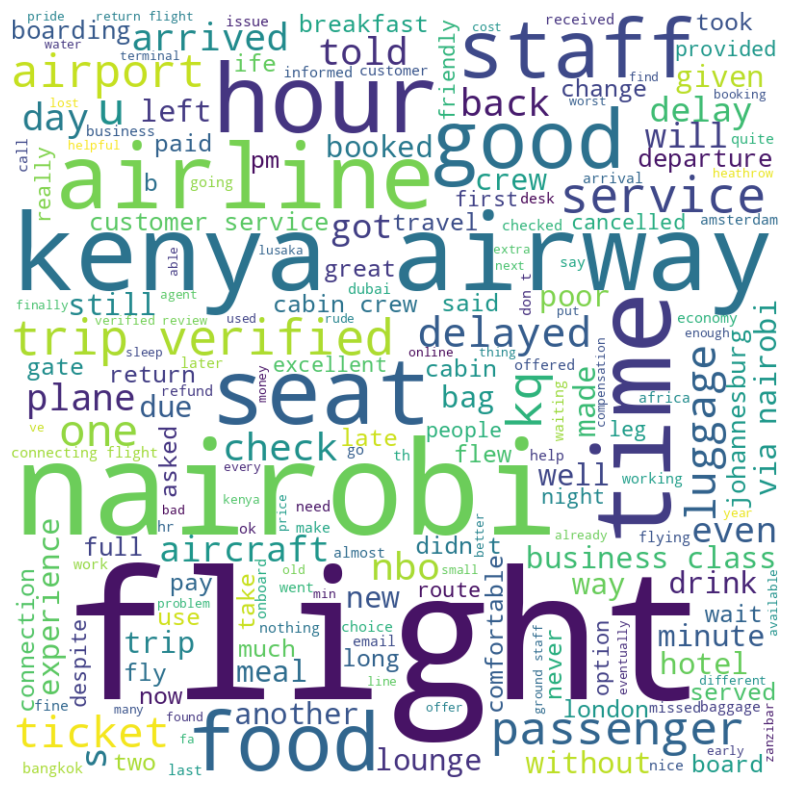

In [58]:
 reviews = " ".join(df.corpus)

# Load the airplane image


# Set stopwords
stopwords = set(STOPWORDS)

# Create a WordCloud instance with the airplane mask
wordcloud = WordCloud(
    width=800,
    height=800,
    background_color="white",
    stopwords=stopwords,
    contour_width=1,
    contour_color="black"
).generate(reviews)

# Display the WordCloud with the airplane mask
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [62]:
#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'kq', "passenger","u","airway","airline",
                                           "nairobi","plane","via","nbo"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

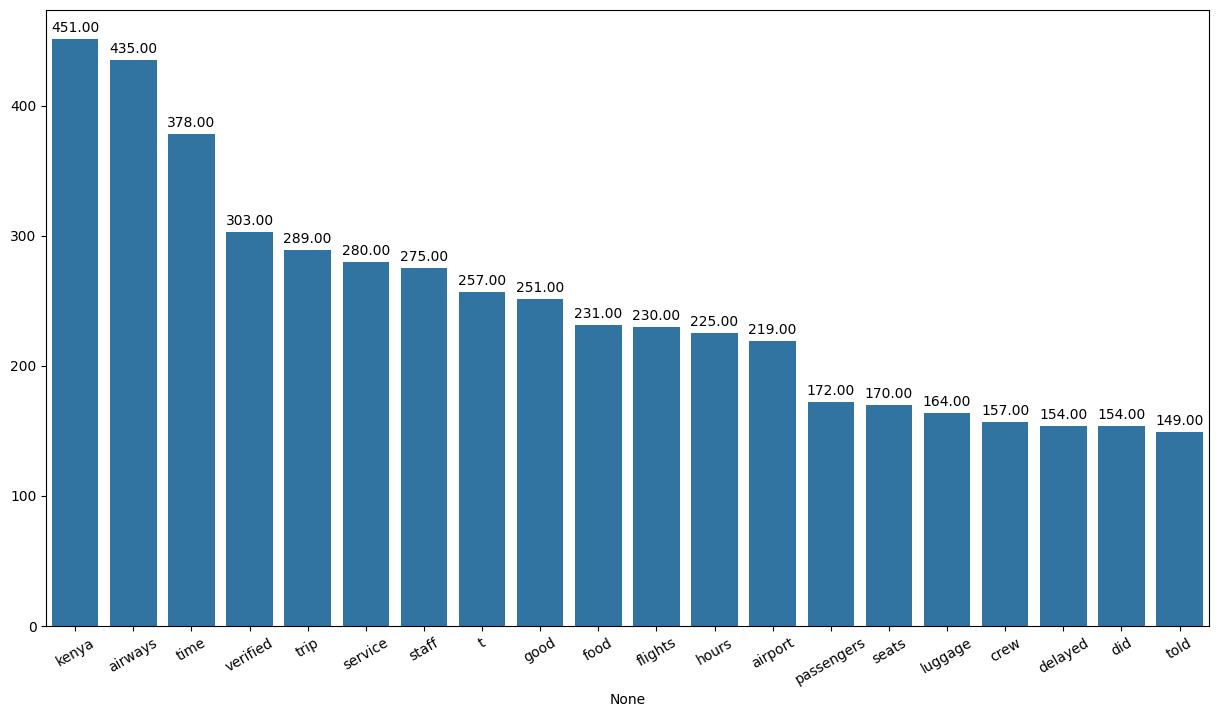

In [60]:
# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15, 8))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)

# Add labels to the bars
for container in all_plot.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=30)

# Display the plot
plt.show()

**Word Frequency using N-gram**


Word frequency with N-grams means looking at how often specific sets of N words appear together in a text. These sets give us insights into word patterns and connections.

<Axes: >

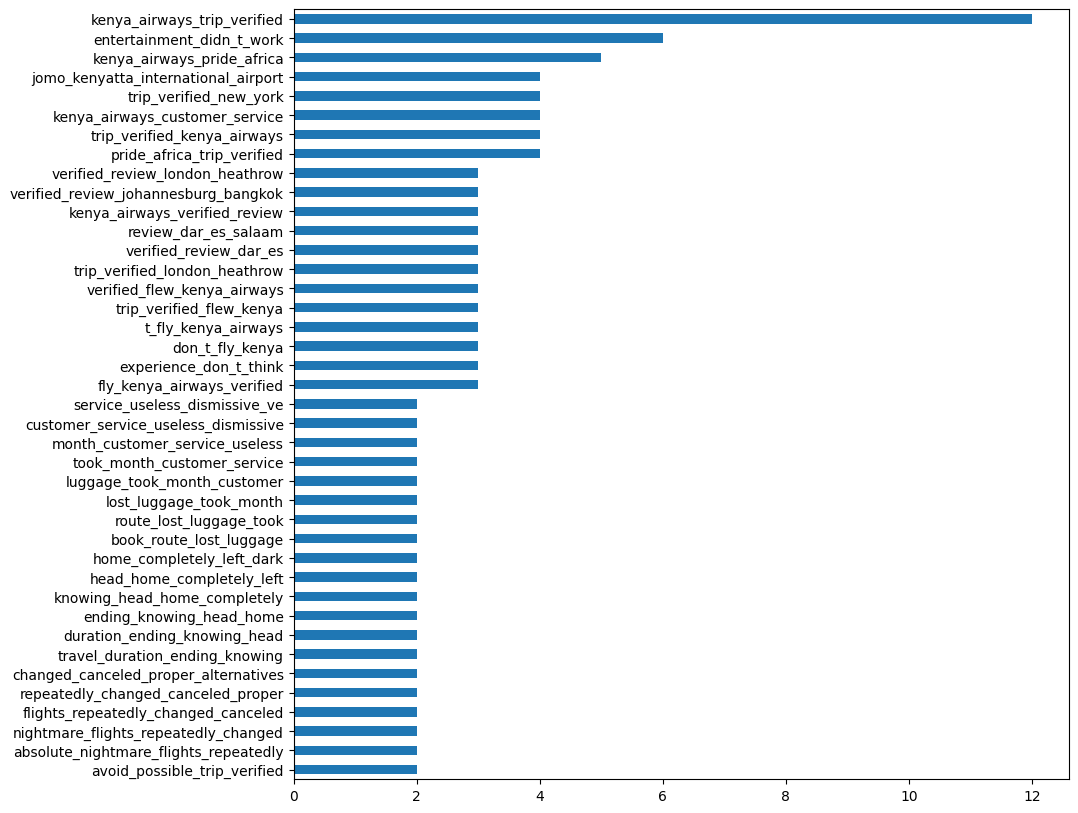

In [63]:
reviews = " ".join(df.corpus)

# Split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words, number_of_ngrams):
    # Generate n-grams
    ngrams_list = list(ngrams(new_words, number_of_ngrams))

    # Creating FreqDist
    ngram_fd = FreqDist(ngrams_list).most_common(40)

    # Sort values by highest frequency
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Join n-gram tokens with '_' and maintain sorting
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Convert to Pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words, 4)

In [64]:
%%capture
vds = SentimentIntensityAnalyzer()

df['label'] = 0

for i in range(len(df.corpus)):

    score = vds.polarity_scores(df.corpus[i])['compound']
    # Positive sentiments
    if score > 0.2:
        df['label'][i] = 1
        # Negative sentiments
    elif score < 0:
        df['label'][i] = -1

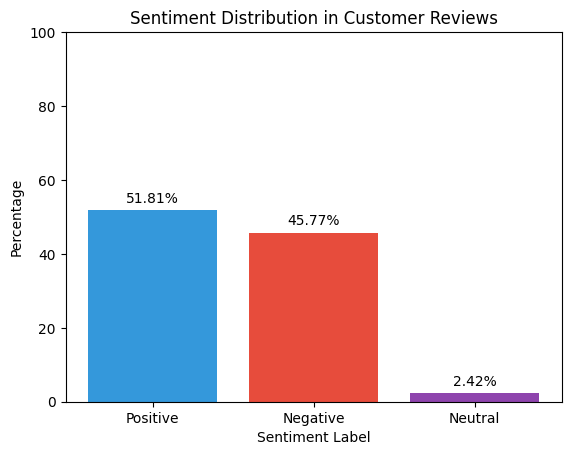

In [65]:
# Calculate label distribution percentages
label_percentages = df.label.value_counts(normalize=True) * 100

# Bar chart
colors = ['#3498db','#e74c3c', '#8e44ad',]
labels = ['Positive', 'Negative', 'Neutral']

plt.bar(labels, label_percentages, color=colors)
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution in Customer Reviews')
plt.ylim(0, 100)

# Display percentages on the bars
for i, percentage in enumerate(label_percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', color='black')

plt.show()

In [66]:
# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [73]:
#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]

df_topic = pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 15 words,Topic 15 weights,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights
0,the,594.7,ata,0.1,in,14.8,who,2.2,was,62.4,...,johannesburg,2.1,ata,0.1,to,1318.6,broken,3.0,the,1327.4
1,and,506.6,competitive,0.1,and,14.8,brussels,2.1,and,52.1,...,jnb,2.1,competitive,0.1,the,1104.5,problems,1.8,to,960.9
2,was,439.9,bombay,0.1,on,11.4,apologies,2.1,flight,32.6,...,phuket,2.0,bombay,0.1,and,612.2,flights,1.8,and,766.3
3,on,265.6,qualm,0.1,nbo,8.0,routed,2.0,to,30.8,...,bangkok,1.9,qualm,0.1,we,530.2,weeks,1.5,was,424.1
4,to,261.7,revamped,0.1,no,8.0,bag,2.0,in,26.0,...,cdg,1.7,revamped,0.1,was,448.3,kq,1.4,in,395.7
5,flight,218.2,tanzania,0.1,flights,7.6,twice,1.9,the,25.3,...,dar,1.2,tanzania,0.1,flight,420.4,stuffy,1.1,of,383.0
6,nairobi,141.0,happily,0.1,to,7.4,south,1.7,time,18.8,...,stuffy,1.1,happily,0.1,in,350.4,unprofessional,1.1,flight,354.5
7,were,139.4,cheerful,0.1,the,7.0,next,1.7,on,18.3,...,impressed,1.1,cheerful,0.1,they,319.0,either,1.1,for,346.7
8,very,134.5,aveled,0.1,but,6.7,drink,1.3,nbo,17.9,...,touch,1.1,aveled,0.1,that,307.8,inbound,1.1,on,336.8
9,in,129.4,easyjet,0.1,as,6.3,usd,1.3,good,16.3,...,inedible,1.1,easyjet,0.1,of,298.6,worst,1.1,at,273.6


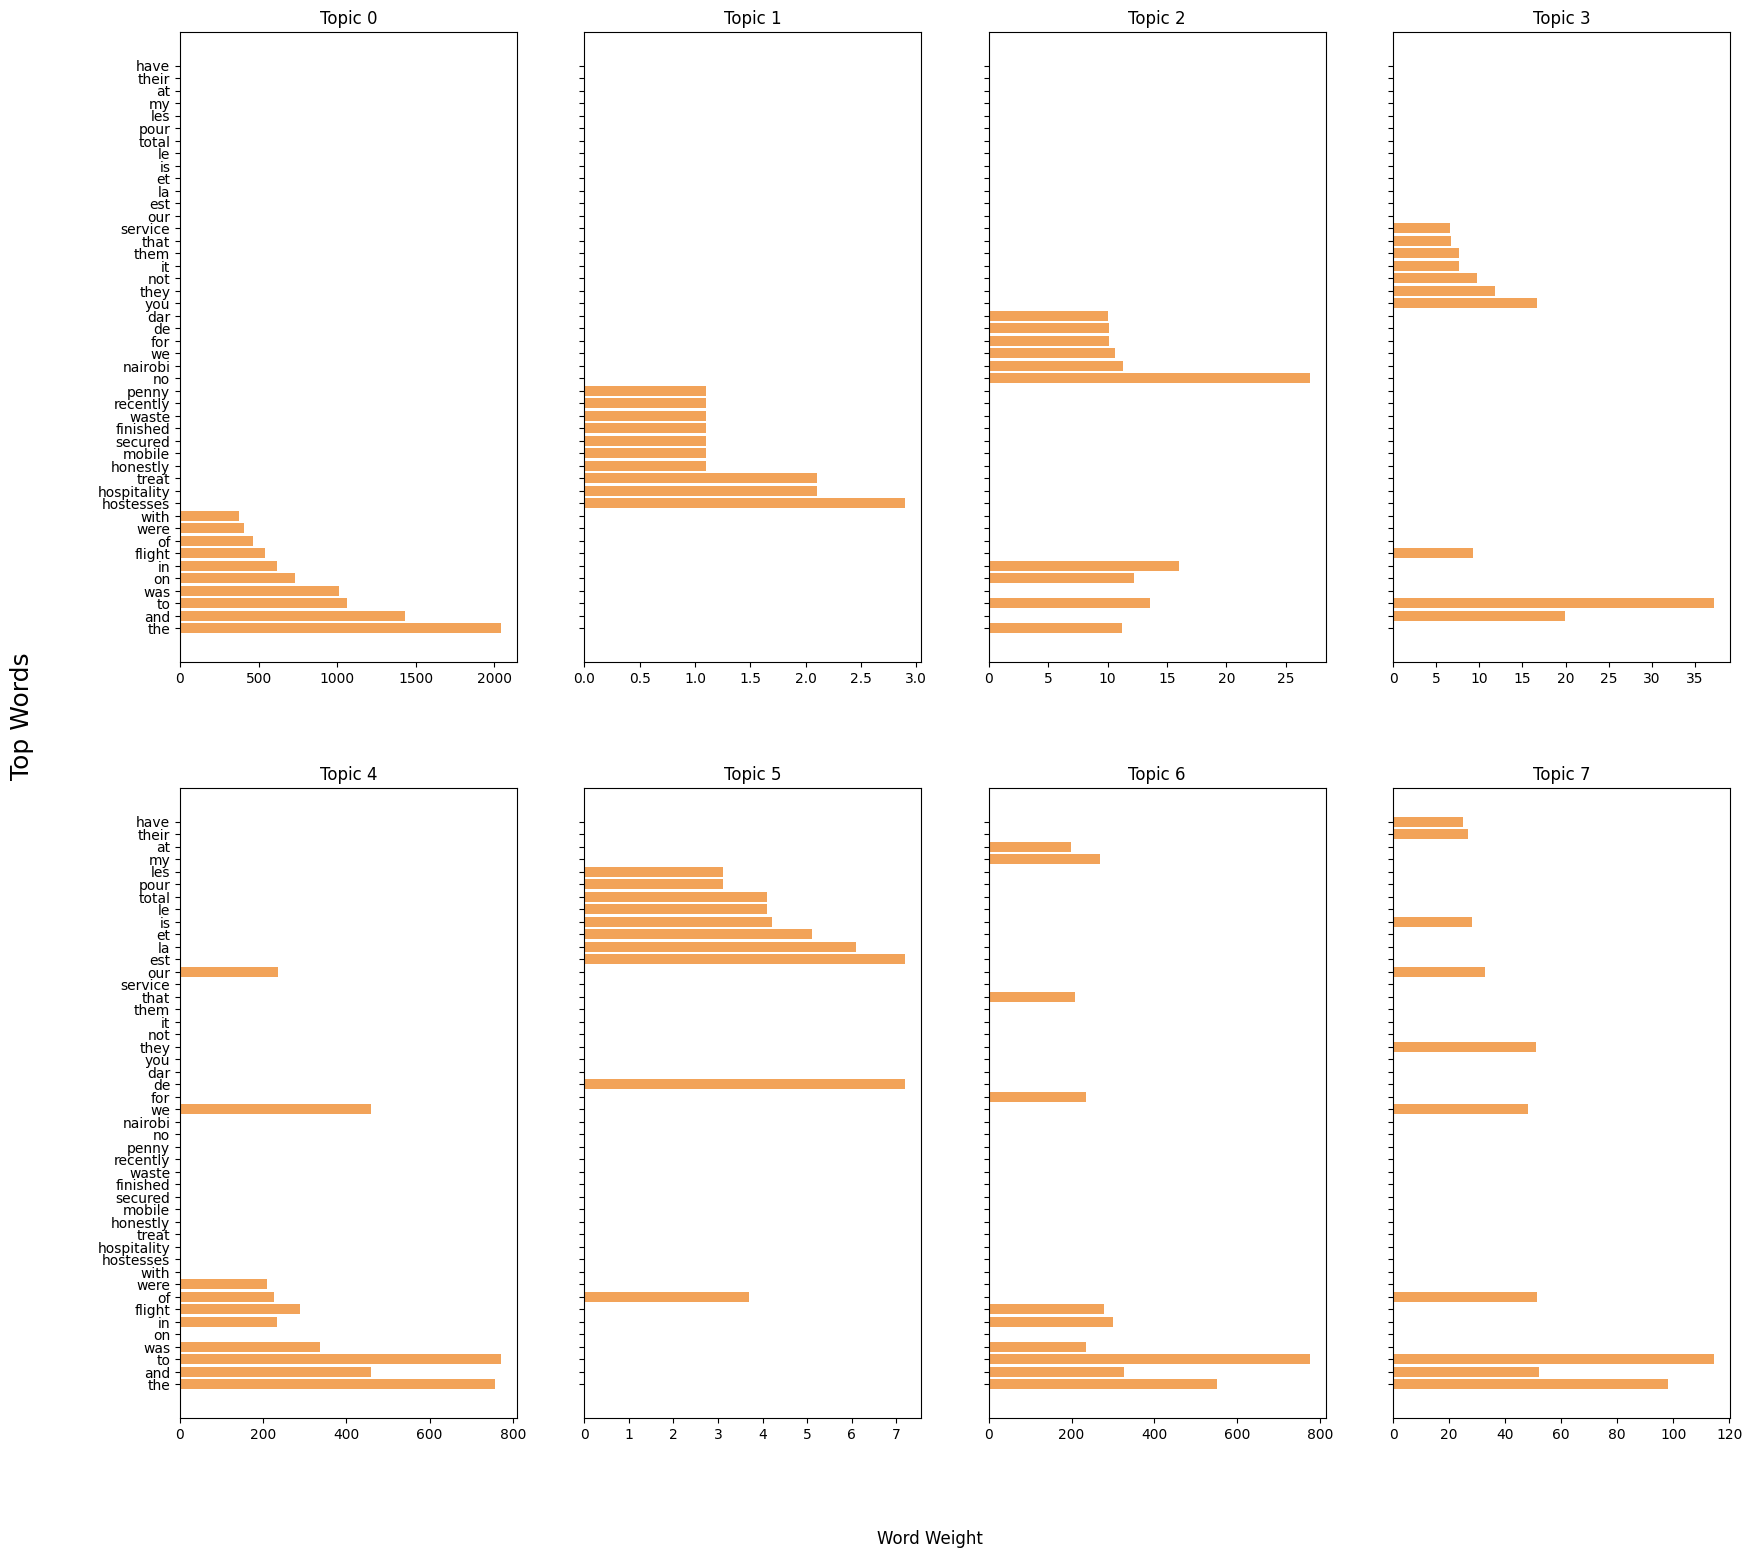

In [37]:
# Create subplots for each topic in a 2x2 grid
fig, axes = plt.subplots(2, 4, figsize=(20,18), sharey=True)

# Flatten the 2D axes array
axes = axes.flatten()

# Iterate over the topics and available subplots
for topic_idx, ax in enumerate(axes):
    if topic_idx < number_of_topics:  # Only plot if there are available subplots
        words = topic_dict[f"Topic {topic_idx} words"]
        weights = [float(w) for w in topic_dict[f"Topic {topic_idx} weights"]]

        ax.barh(words, weights, color='#f2a359')
        ax.set_title(f"Topic {topic_idx}")
        ax.invert_yaxis()

# Add common labels
fig.text(0.5, 0.04, 'Word Weight', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Top Words', va='center', rotation='vertical', fontsize=18)

plt.show()

**Unsupervised Learning Models**


Topic modeling with **NMF**


Topic modeling with NMF enhances NLP sentiment analysis by revealing underlying themes in text. It provides context, granularity, and insights, enabling more personalized responses and understanding of complex sentiments within specific topics.

In [38]:
# Specify the number of components/topics for NMF
num_components = 10

# Create an NMF model with specified components and initialization method
# Using 'random' initialization and setting a random state for reproducibility
nmf = NMF(n_components=num_components, init='random', random_state=0)

# Fit the NMF model to the given term-frequency matrix (tf)
# The NMF model will learn the latent topics from the matrix
nmf.fit_transform(tf)

array([[0.01805115, 0.04194822, 0.        , ..., 0.1016348 , 0.05582144,
        0.01604903],
       [0.18223089, 0.09963369, 0.        , ..., 0.        , 0.20970116,
        0.        ],
       [0.        , 0.32754547, 0.47455834, ..., 0.        , 0.432473  ,
        0.        ],
       ...,
       [0.10188896, 0.32155093, 0.        , ..., 0.08228025, 0.40699121,
        0.08997963],
       [0.00690705, 0.        , 0.06671581, ..., 0.025959  , 0.        ,
        0.0321394 ],
       [0.        , 0.        , 0.10140236, ..., 0.0684232 , 0.24968147,
        0.04119804]])

In [39]:
topic_dict = {}

#loop through model components
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]

df_topic =pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,to,19.0,to,9.4,and,11.0,was,125.9,we,45.7,to,63.3,flight,29.4,in,14.9,the,18.7,is,29.1
1,of,9.7,at,4.9,on,6.3,flight,34.0,our,18.4,and,52.2,the,24.9,to,4.7,and,2.7,the,20.9
2,this,2.5,flight,2.6,good,2.1,it,25.5,were,14.7,my,50.8,kenya,20.2,were,2.2,of,1.0,of,15.8
3,our,2.2,nairobi,1.8,very,2.1,for,20.8,to,12.9,me,33.0,airways,19.9,was,2.2,at,0.9,for,15.4
4,from,1.9,am,1.5,were,2.0,but,15.5,us,12.7,they,30.3,on,12.7,lounge,2.1,would,0.6,and,14.0
5,with,1.7,from,1.4,with,1.6,not,14.7,and,10.8,that,27.4,nairobi,9.8,nairobi,2.1,staff,0.6,it,12.5
6,had,1.6,pm,1.3,food,1.5,time,12.4,that,9.5,was,18.5,with,8.3,had,1.8,passengers,0.5,no,11.9
7,in,1.6,no,1.2,time,1.4,were,10.2,they,8.8,it,15.2,that,8.0,as,1.8,on,0.5,not,11.6
8,have,1.4,for,1.1,but,1.3,seat,9.9,had,8.4,had,14.7,from,6.8,my,1.7,with,0.5,you,10.8
9,on,1.3,be,1.1,seats,1.2,crew,8.7,at,4.0,for,13.8,in,5.3,luggage,1.6,were,0.5,are,9.7


**Supervised Learning Models**

In [40]:
# Convert continuous sentiment scores to categorical labels
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x > 0.2 else -1)
df['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
-1,0.554435
1,0.445565


In [41]:
# Training and Test split

X = df['corpus']  # Features
y = df['sentiment']   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Feature Extraction

vect = CountVectorizer()
x_train_vect = vect.fit_transform(X_train)
x_test_vect = vect.transform(X_test)

**Logistic Regression**

In [43]:
# Instantiate Logistic Regression

model = LogisticRegression()
model.fit(x_train_vect, y_train)

# Model Evaluation
y_pred = model.predict(x_test_vect)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on test data: 0.85
Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.90      0.85        49
           1       0.89      0.80      0.85        51

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



**Model Summary**

The logistic regression model achieved an accuracy of 0.86 on the test data. It demonstrates good precision and recall for class -1 and class 1. The decision tree model was employed to explore potential performance improvement due to its ability to capture nonlinear relationships and interactions. If the decision tree model outperforms, it suggests that complex data interactions play a role in prediction accuracy.

**Decision Tree Model**

In [44]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train_vect, y_train)

# Model Evaluation

dt_y_pred = dt_model.predict(x_test_vect)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred))

Decision Tree Accuracy: 0.68
Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       0.67      0.67      0.67        49
           1       0.69      0.69      0.69        51

    accuracy                           0.68       100
   macro avg       0.68      0.68      0.68       100
weighted avg       0.68      0.68      0.68       100



**Model Summary**

The decision tree model achieved an accuracy of 0.65 on the test data. It exhibited varying precision and recall for different classes, with class -1 and class 1 showing moderate performance. In comparison, the logistic regression model had a higher accuracy of 0.89 and demonstrated better precision and recall scores for most classes. Given the decision tree's modest performance and its sensitivity to overfitting, a more robust ensemble model like Random Forest was chosen to enhance performance. Random Forest leverages multiple decision trees to reduce overfitting and increase predictive accuracy by aggregating their outputs.

**Random Forest Mode**l

In [45]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train_vect, y_train)

# Model Evaluation

rf_y_pred = rf_model.predict(x_test_vect)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Accuracy: 0.83
Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.90      0.84        49
           1       0.89      0.76      0.82        51

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



**Model Summary**

The Random Forest model achieved an accuracy of 0.78 on the test data. It demonstrated good precision and recall for class -1 and class 1, similar to the logistic regression model. In comparison, the decision tree model had an accuracy of 0.70 and showed limited performance.

To explore further improvements, the Support Vector Machine (SVM) model was built. SVM is capable of handling both linear and nonlinear relationships and can effectively capture complex decision boundaries. If the SVM model yields better results, it suggests that the data might have nonlinear patterns that other models fail to capture. Additionally, SVM's ability to handle high-dimensional data and maximize margins between classes makes it a valuable candidate for enhancing model performance.

**Support Vector Machine Model**

In [46]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(x_train_vect, y_train)

# Model Evaluation

svm_y_pred = svm_model.predict(x_test_vect)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print("SVM Classification Report:")
print(classification_report(y_test, svm_y_pred))

SVM Accuracy: 0.74
SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.80      0.75        49
           1       0.78      0.69      0.73        51

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



Model **Summary**


The SVM model achieved an accuracy of 0.74 on the test data, demonstrating good precision and recall for class -1 and class 1, similar to the Random Forest and logistic regression models. To further enhance model performance, the XGBoost model was chosen. XGBoost's ability to handle complex relationships, address overfitting, and boost model accuracy makes it a strong candidate for improving overall performance. Its iterative boosting approach and flexibility are well-suited for challenging scenarios.

**Model Evaluation**


Among the models mentioned, the Logistic Regression model achieved the best performance for sentiment classification, with an accuracy of 0.89 on the test data. This model demonstrated balanced precision, recall, and F1-score metrics across different sentiment classes, indicating its ability to accurately classify both positive and negative sentiments. As it was the best performing model, it was used during the deployment process of the Sky Opinion Sentiment Classifier App. It was deployed and hosted on Streamlit and can be accessed by following this link

In [47]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('logreg', LogisticRegression())
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predictions on the testing data
y_pred = pipeline.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.90      0.85        49
           1       0.89      0.80      0.85        51

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



**Conclusion**

**Model Performance**: The Logistic Regression model achieved the highest accuracy of 0.85 on the test data, making it the best-performing model among those evaluated.

**Class Imbalance**: While evaluating the models, it's evident that there is some class imbalance, especially for the neutral class (label 0), which had very few instances. This can impact the model's ability to correctly predict this class.

**Model Selection:** It's important to choose a model that aligns with the specific goals of the sentiment analysis task. In this case, Logistic Regression proved to be effective, but other models like Decision Trees, Random Forest, Support Vector Machines (SVM), were also explored.

**Model Improvement:** Different models were used to check for potential improvements in performance. For example, Random Forest  were used to address potential weaknesses in Decision Trees, and SVM was used as another classification approach.

**Interpretability vs. Complexity**: Decision Trees and Logistic Regression are relatively interpretable models, which makes it easier to understand how they arrive at their predictions. On the other hand, models like Random Forest and XGBoost are more complex ensemble methods that might achieve higher accuracy but are harder to interpret.

**Recommendations**




**Regular Feedback Collection**: Establish a system for collecting continuous feedback from passengers, both during and after their travel experience. This can provide valuable insights into areas that need improvement and help in addressing issues promptly.

**Social Media Engagement:** Actively engage with passengers on social media platforms to address their concerns and provide real-time assistance. Monitor social media channels for feedback and respond promptly.

**Punctuality Improvement:** Negative sentiments regarding flight delays and inconsistent departure times should be addressed. Focus on improving punctuality to provide a smoother travel experience for passengers.

**Customer Service Enhancement:** Address negative sentiments related to customer service, such as rude behavior of staff, unhelpful responses, and long wait times. Implement training programs to ensure that staff are courteous and responsive to passenger needs.

**Communication:** Enhance communication with passengers regarding flight updates, delays, and any changes. Keeping passengers informed in a timely and transparent manner can help manage expectations and reduce frustration.

**Passenger Comfort:** Pay attention to sentiments related to seating, legroom, and overall comfort during the flight. Consider offering amenities and services that improve passenger comfort, especially on long-haul flights.